<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Adaboost(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [4]:
# Step 2: Define the AdaBoost 5-Class Production Classifier
class AdaBoostProductionClassifier:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None
        self.class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("Loading datasets...")

        # Load datasets
        train_df = pd.read_csv(train_path)
        val_df = pd.read_csv(val_path)
        test_df = pd.read_csv(test_path)

        print(f"Train set shape: {train_df.shape}")
        print(f"Validation set shape: {val_df.shape}")
        print(f"Test set shape: {test_df.shape}")

        # Create labels based on production quintiles (using training data for 5 classes)
        production_col = 'Production (M.Ton)'

        # Calculate quintiles from training data (20%, 40%, 60%, 80%)
        quantiles = train_df[production_col].quantile([0.20, 0.40, 0.60, 0.80]).values
        print(f"Production quintiles:")
        print(f"Very Low: <{quantiles[0]:.2f}")
        print(f"Low: {quantiles[0]:.2f}-{quantiles[1]:.2f}")
        print(f"Medium: {quantiles[1]:.2f}-{quantiles[2]:.2f}")
        print(f"High: {quantiles[2]:.2f}-{quantiles[3]:.2f}")
        print(f"Very High: >{quantiles[3]:.2f}")

        # Create labels for all datasets
        def create_labels(df, q1, q2, q3, q4):
            labels = []
            for prod in df[production_col]:
                if prod <= q1:
                    labels.append('Very Low')
                elif prod <= q2:
                    labels.append('Low')
                elif prod <= q3:
                    labels.append('Medium')
                elif prod <= q4:
                    labels.append('High')
                else:
                    labels.append('Very High')
            return labels

        train_df['Label'] = create_labels(train_df, quantiles[0], quantiles[1], quantiles[2], quantiles[3])
        val_df['Label'] = create_labels(val_df, quantiles[0], quantiles[1], quantiles[2], quantiles[3])
        test_df['Label'] = create_labels(test_df, quantiles[0], quantiles[1], quantiles[2], quantiles[3])

        # Separate features and labels
        feature_cols = [col for col in train_df.columns if col not in [production_col, 'Label']]
        self.feature_names = feature_cols

        X_train = train_df[feature_cols]
        y_train = train_df['Label']
        X_val = val_df[feature_cols]
        y_val = val_df['Label']
        X_test = test_df[feature_cols]
        y_test = test_df['Label']

        # Handle missing values
        X_train = X_train.fillna(X_train.mean())
        X_val = X_val.fillna(X_train.mean())  # Use training mean for consistency
        X_test = X_test.fillna(X_train.mean())

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)

        print("\nLabel distribution:")
        print("Training:", pd.Series(y_train).value_counts().sort_index())
        print("Validation:", pd.Series(y_val).value_counts().sort_index())
        print("Testing:", pd.Series(y_test).value_counts().sort_index())

        return (X_train_scaled, X_val_scaled, X_test_scaled,
                y_train_encoded, y_val_encoded, y_test_encoded,
                y_train, y_val, y_test)

    def train_model_with_epochs(self, X_train, y_train, X_val, y_val, n_epochs=100):
        """Train AdaBoost model with epoch-like iterations"""
        print(f"\nTraining AdaBoost model with {n_epochs} estimators...")

        # Initialize model with adjusted parameters for 5-class classification
        base_estimator = DecisionTreeClassifier(max_depth=6, random_state=42)  # Increased depth for more classes
        self.model = AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_epochs,
            learning_rate=0.3,  # Reduced learning rate for better convergence
            algorithm='SAMME',  # Better for multiclass problems
            random_state=42
        )

        # For tracking performance over epochs
        train_accuracies = []
        val_accuracies = []
        epochs = []

        # Train with increasing number of estimators to simulate epochs
        for n_est in range(10, n_epochs + 1, 10):
            temp_model = AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=6, random_state=42),
                n_estimators=n_est,
                learning_rate=0.3,
                algorithm='SAMME',
                random_state=42
            )
            temp_model.fit(X_train, y_train)

            train_pred = temp_model.predict(X_train)
            val_pred = temp_model.predict(X_val)

            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            epochs.append(n_est)

            if n_est % 20 == 0:
                print(f"Estimators: {n_est}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Final training
        self.model.fit(X_train, y_train)
        print("Training completed!")

        return epochs, train_accuracies, val_accuracies

    def calculate_metrics(self, y_true, y_pred, dataset_name):
        """Calculate comprehensive classification metrics"""
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

        print(f"\n{dataset_name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"F1-Score (Macro): {f1_macro:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro
        }

    def plot_confusion_matrix(self, y_true, y_pred, title):
        """Plot confusion matrix for 5 classes"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))  # Larger size for 5x5 matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title(f'Confusion Matrix - {title}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        return cm

    def plot_training_curves(self, epochs, train_acc, val_acc):
        """Plot training vs validation accuracy"""
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy (5-Class)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, np.array(train_acc) - np.array(val_acc), 'g-', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Training - Validation Accuracy')
        plt.title('Overfitting Analysis')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=15):
        """Plot feature importance"""
        if self.model is None:
            print("Model not trained yet!")
            return

        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importance (5-Class Classification)')
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [self.feature_names[i] for i in indices])
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def generate_classification_report(self, y_true, y_pred, dataset_name):
        """Generate detailed classification report"""
        print(f"\n{dataset_name} Classification Report:")
        print("=" * 60)
        report = classification_report(y_true, y_pred,
                                     target_names=self.class_names,
                                     digits=4)
        print(report)
        return report

    def plot_class_distribution(self, y_train, y_val, y_test):
        """Plot class distribution across datasets"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        datasets = [y_train, y_val, y_test]
        titles = ['Training Set', 'Validation Set', 'Test Set']

        for i, (data, title) in enumerate(zip(datasets, titles)):
            counts = pd.Series(data).value_counts().sort_index()
            axes[i].bar(range(len(counts)), counts.values)
            axes[i].set_title(f'{title} Distribution')
            axes[i].set_xlabel('Classes')
            axes[i].set_ylabel('Count')
            axes[i].set_xticks(range(len(self.class_names)))
            axes[i].set_xticklabels(self.class_names, rotation=45)

        plt.tight_layout()
        plt.show()

print("✅ AdaBoostProductionClassifier class defined successfully!")

✅ AdaBoostProductionClassifier class defined successfully!


In [5]:
# Step 3: Initialize classifier and set file paths
classifier = AdaBoostProductionClassifier()

# File paths - UPDATE THESE PATHS TO MATCH YOUR FILE LOCATIONS
train_path = '/content/drive/MyDrive/UpdatedDataset/train.csv'
val_path = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
test_path = '/content/drive/MyDrive/UpdatedDataset/test.csv'

print("✅ Classifier initialized and file paths set!")
print(f"Train path: {train_path}")
print(f"Validation path: {val_path}")
print(f"Test path: {test_path}")

✅ Classifier initialized and file paths set!
Train path: /content/drive/MyDrive/UpdatedDataset/train.csv
Validation path: /content/drive/MyDrive/UpdatedDataset/validation.csv
Test path: /content/drive/MyDrive/UpdatedDataset/test.csv


In [6]:


# Step 4: Load and preprocess the datasets
print("="*60)
print("STEP 4: LOADING AND PREPROCESSING DATA")
print("="*60)

try:
    (X_train, X_val, X_test,
     y_train_enc, y_val_enc, y_test_enc,
     y_train_orig, y_val_orig, y_test_orig) = classifier.load_and_preprocess_data(
        train_path, val_path, test_path)

    print("✅ Data loading and preprocessing completed successfully!")
    print(f"Feature shape: {X_train.shape}")
    print(f"Number of features: {len(classifier.feature_names)}")

except Exception as e:
    print(f"❌ Error in data loading: {e}")
    print("Please check your file paths and ensure the CSV files exist.")

STEP 4: LOADING AND PREPROCESSING DATA
Loading datasets...
Train set shape: (3942, 84)
Validation set shape: (845, 84)
Test set shape: (845, 84)
Production quintiles:
Very Low: <578.00
Low: 578.00-1463.00
Medium: 1463.00-3119.52
High: 3119.52-6540.92
Very High: >6540.92

Label distribution:
Training: Label
High         788
Low          786
Medium       786
Very High    789
Very Low     793
Name: count, dtype: int64
Validation: Label
High         160
Low          140
Medium       191
Very High    169
Very Low     185
Name: count, dtype: int64
Testing: Label
High         175
Low          158
Medium       167
Very High    173
Very Low     172
Name: count, dtype: int64
✅ Data loading and preprocessing completed successfully!
Feature shape: (3942, 83)
Number of features: 83


STEP 5: VISUALIZING CLASS DISTRIBUTION


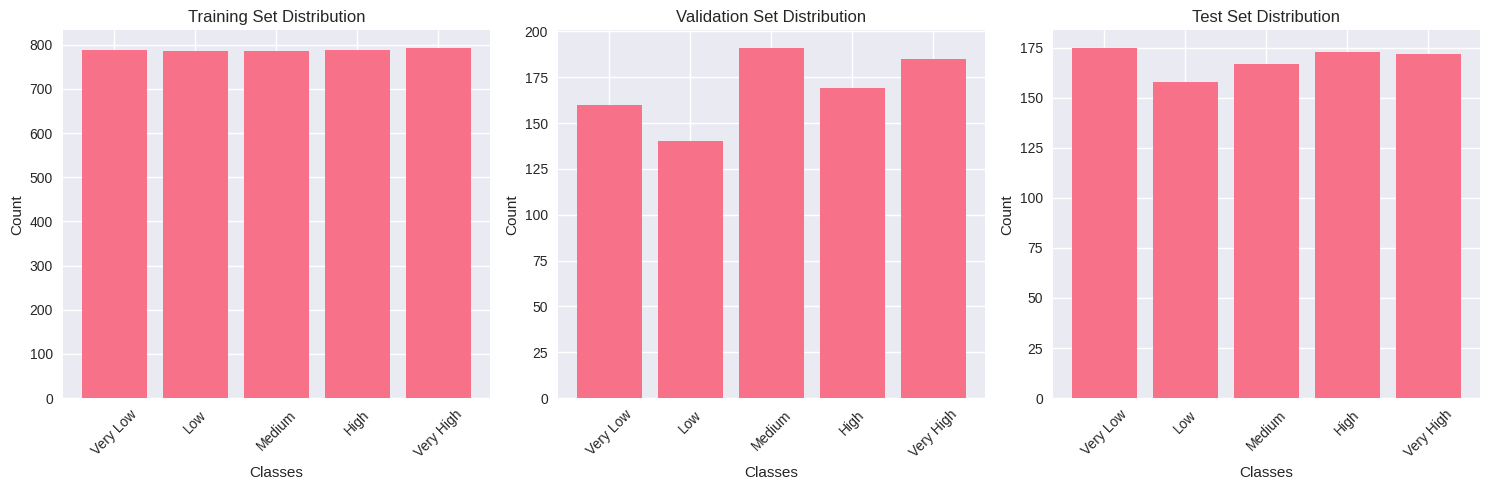

✅ Class distribution visualization completed!


In [7]:
# Step 5: Visualize class distribution
print("="*60)
print("STEP 5: VISUALIZING CLASS DISTRIBUTION")
print("="*60)

try:
    classifier.plot_class_distribution(y_train_orig, y_val_orig, y_test_orig)
    print("✅ Class distribution visualization completed!")

except Exception as e:
    print(f"❌ Error in plotting class distribution: {e}")

In [8]:
# Step 6: Train the AdaBoost model
print("="*60)
print("STEP 6: TRAINING MODEL")
print("="*60)

try:
    epochs, train_acc, val_acc = classifier.train_model_with_epochs(
        X_train, y_train_enc, X_val, y_val_enc, n_epochs=160)  # Increased epochs for 5 classes

    print("✅ Model training completed successfully!")
    print(f"Final training accuracy: {train_acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")

except Exception as e:
    print(f"❌ Error in model training: {e}")

STEP 6: TRAINING MODEL

Training AdaBoost model with 160 estimators...
Estimators: 20, Train Acc: 0.8384, Val Acc: 0.7941
Estimators: 40, Train Acc: 0.8757, Val Acc: 0.8000
Estimators: 60, Train Acc: 0.8889, Val Acc: 0.8047
Estimators: 80, Train Acc: 0.8995, Val Acc: 0.8107
Estimators: 100, Train Acc: 0.9160, Val Acc: 0.7964
Estimators: 120, Train Acc: 0.9226, Val Acc: 0.8036
Estimators: 140, Train Acc: 0.9249, Val Acc: 0.8000
Estimators: 160, Train Acc: 0.9363, Val Acc: 0.8118
Training completed!
✅ Model training completed successfully!
Final training accuracy: 0.9363
Final validation accuracy: 0.8118


In [9]:

# Step 7: Make predictions on all datasets
print("="*60)
print("STEP 7: MAKING PREDICTIONS")
print("="*60)

try:
    train_pred = classifier.model.predict(X_train)
    val_pred = classifier.model.predict(X_val)
    test_pred = classifier.model.predict(X_test)

    print("✅ Predictions completed successfully!")
    print(f"Training predictions shape: {train_pred.shape}")
    print(f"Validation predictions shape: {val_pred.shape}")
    print(f"Test predictions shape: {test_pred.shape}")

except Exception as e:
    print(f"❌ Error in making predictions: {e}")

STEP 7: MAKING PREDICTIONS
✅ Predictions completed successfully!
Training predictions shape: (3942,)
Validation predictions shape: (845,)
Test predictions shape: (845,)


In [10]:
# Step 8: Calculate evaluation metrics
print("="*60)
print("STEP 8: EVALUATION METRICS")
print("="*60)

try:
    train_metrics = classifier.calculate_metrics(y_train_enc, train_pred, "TRAINING")
    val_metrics = classifier.calculate_metrics(y_val_enc, val_pred, "VALIDATION")
    test_metrics = classifier.calculate_metrics(y_test_enc, test_pred, "TESTING")

    print("✅ Metrics calculation completed successfully!")

except Exception as e:
    print(f"❌ Error in calculating metrics: {e}")

STEP 8: EVALUATION METRICS

TRAINING Metrics:
Accuracy: 0.9363
Precision (Weighted): 0.9367
Recall (Weighted): 0.9363
F1-Score (Weighted): 0.9364
F1-Score (Macro): 0.9363

VALIDATION Metrics:
Accuracy: 0.8118
Precision (Weighted): 0.8160
Recall (Weighted): 0.8118
F1-Score (Weighted): 0.8133
F1-Score (Macro): 0.8095

TESTING Metrics:
Accuracy: 0.8189
Precision (Weighted): 0.8249
Recall (Weighted): 0.8189
F1-Score (Weighted): 0.8209
F1-Score (Macro): 0.8199
✅ Metrics calculation completed successfully!


In [11]:

# Step 9: Generate detailed classification reports
print("="*60)
print("STEP 9: DETAILED CLASSIFICATION REPORTS")
print("="*60)

try:
    classifier.generate_classification_report(y_train_enc, train_pred, "TRAINING")
    classifier.generate_classification_report(y_val_enc, val_pred, "VALIDATION")
    classifier.generate_classification_report(y_test_enc, test_pred, "TESTING")

    print("✅ Classification reports generated successfully!")

except Exception as e:
    print(f"❌ Error in generating classification reports: {e}")

STEP 9: DETAILED CLASSIFICATION REPORTS

TRAINING Classification Report:
              precision    recall  f1-score   support

    Very Low     0.9165    0.9048    0.9106       788
         Low     0.9400    0.9173    0.9285       786
      Medium     0.8843    0.9237    0.9035       786
        High     0.9611    0.9404    0.9507       789
   Very High     0.9813    0.9950    0.9881       793

    accuracy                         0.9363      3942
   macro avg     0.9366    0.9362    0.9363      3942
weighted avg     0.9367    0.9363    0.9364      3942


VALIDATION Classification Report:
              precision    recall  f1-score   support

    Very Low     0.7262    0.7625    0.7439       160
         Low     0.7013    0.7714    0.7347       140
      Medium     0.7541    0.7225    0.7380       191
        High     0.9136    0.8757    0.8943       169
   Very High     0.9551    0.9189    0.9366       185

    accuracy                         0.8118       845
   macro avg     0.8100

STEP 10: PLOTTING TRAINING CURVES


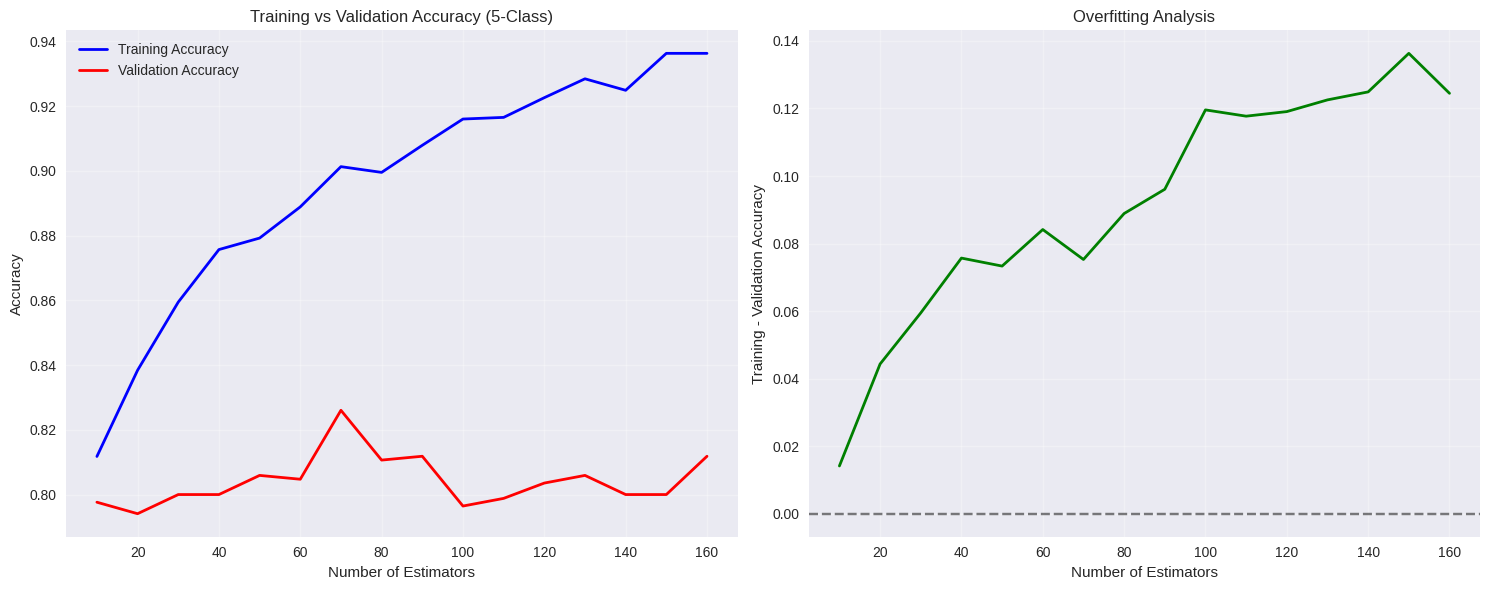

✅ Training curves plotted successfully!


In [12]:
# Step 10: Plot training curves
print("="*60)
print("STEP 10: PLOTTING TRAINING CURVES")
print("="*60)

try:
    classifier.plot_training_curves(epochs, train_acc, val_acc)
    print("✅ Training curves plotted successfully!")

except Exception as e:
    print(f"❌ Error in plotting training curves: {e}")

STEP 11: PLOTTING CONFUSION MATRICES
Validation Set Confusion Matrix:


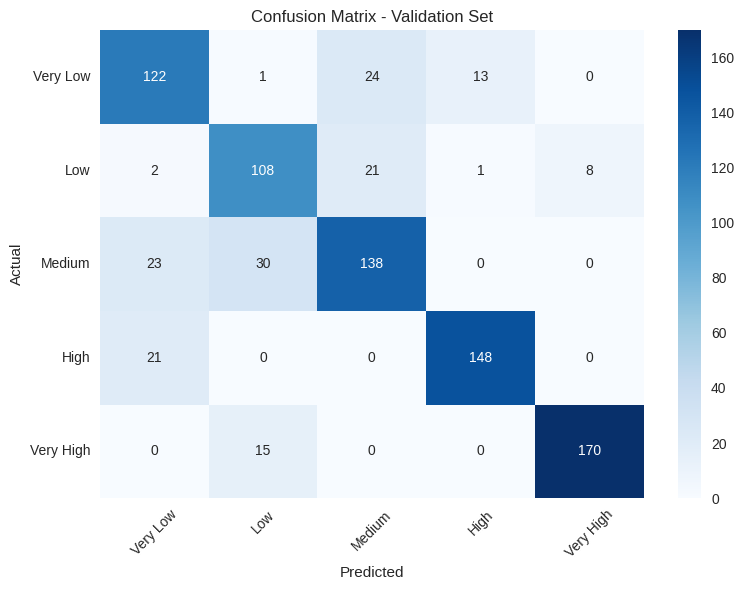


Test Set Confusion Matrix:


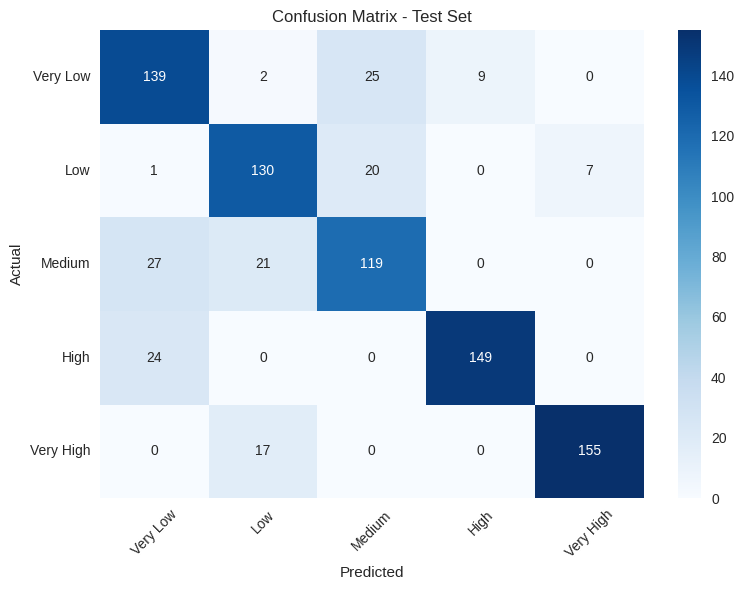

✅ Confusion matrices plotted successfully!


In [13]:
# Step 11: Plot confusion matrices
print("="*60)
print("STEP 11: PLOTTING CONFUSION MATRICES")
print("="*60)

try:
    print("Validation Set Confusion Matrix:")
    cm_val = classifier.plot_confusion_matrix(y_val_enc, val_pred, "Validation Set")

    print("\nTest Set Confusion Matrix:")
    cm_test = classifier.plot_confusion_matrix(y_test_enc, test_pred, "Test Set")

    print("✅ Confusion matrices plotted successfully!")

except Exception as e:
    print(f"❌ Error in plotting confusion matrices: {e}")

STEP 12: PLOTTING FEATURE IMPORTANCE


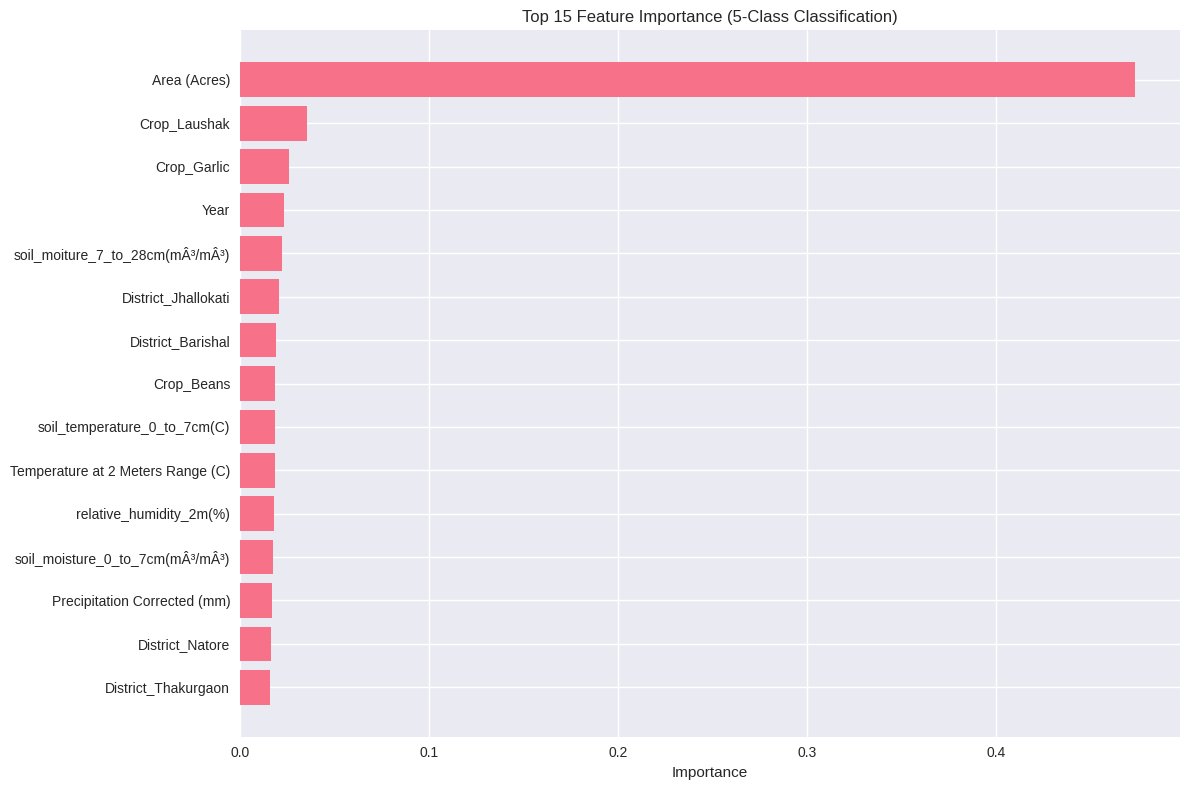

✅ Feature importance plot generated successfully!


In [14]:
# Step 12: Plot feature importance
print("="*60)
print("STEP 12: PLOTTING FEATURE IMPORTANCE")
print("="*60)

try:
    classifier.plot_feature_importance(top_n=15)
    print("✅ Feature importance plot generated successfully!")

except Exception as e:
    print(f"❌ Error in plotting feature importance: {e}")

In [15]:
# Step 13: Generate final performance summary
print("="*60)
print("STEP 13: FINAL PERFORMANCE SUMMARY")
print("="*60)

try:
    summary_df = pd.DataFrame({
        'Dataset': ['Training', 'Validation', 'Testing'],
        'Accuracy': [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']],
        'Precision': [train_metrics['precision'], val_metrics['precision'], test_metrics['precision']],
        'Recall': [train_metrics['recall'], val_metrics['recall'], test_metrics['recall']],
        'F1-Weighted': [train_metrics['f1_weighted'], val_metrics['f1_weighted'], test_metrics['f1_weighted']],
        'F1-Macro': [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']]
    })

    print("\nFinal Performance Summary (5-Class Classification):")
    print(summary_df.round(4))

    # Macro F1 Score emphasis
    print(f"\nMACRO F1 SCORES:")
    print(f"Training:   {train_metrics['f1_macro']:.4f}")
    print(f"Validation: {val_metrics['f1_macro']:.4f}")
    print(f"Testing:    {test_metrics['f1_macro']:.4f}")

    # Performance insights for 5-class classification
    print(f"\n📊 PERFORMANCE INSIGHTS:")
    best_f1 = max(train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro'])
    if best_f1 > 0.8:
        print("🟢 Excellent performance for 5-class classification!")
    elif best_f1 > 0.6:
        print("🟡 Good performance for 5-class classification")
    else:
        print("🔴 Consider tuning hyperparameters for better performance")

    print("\n✅ All steps completed successfully!")
    print("🎉 AdaBoost 5-Class Classification Pipeline Finished!")

except Exception as e:
    print(f"❌ Error in final summary: {e}")

STEP 13: FINAL PERFORMANCE SUMMARY

Final Performance Summary (5-Class Classification):
      Dataset  Accuracy  Precision  Recall  F1-Weighted  F1-Macro
0    Training    0.9363     0.9367  0.9363       0.9364    0.9363
1  Validation    0.8118     0.8160  0.8118       0.8133    0.8095
2     Testing    0.8189     0.8249  0.8189       0.8209    0.8199

MACRO F1 SCORES:
Training:   0.9363
Validation: 0.8095
Testing:    0.8199

📊 PERFORMANCE INSIGHTS:
🟢 Excellent performance for 5-class classification!

✅ All steps completed successfully!
🎉 AdaBoost 5-Class Classification Pipeline Finished!
